In [1]:
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 


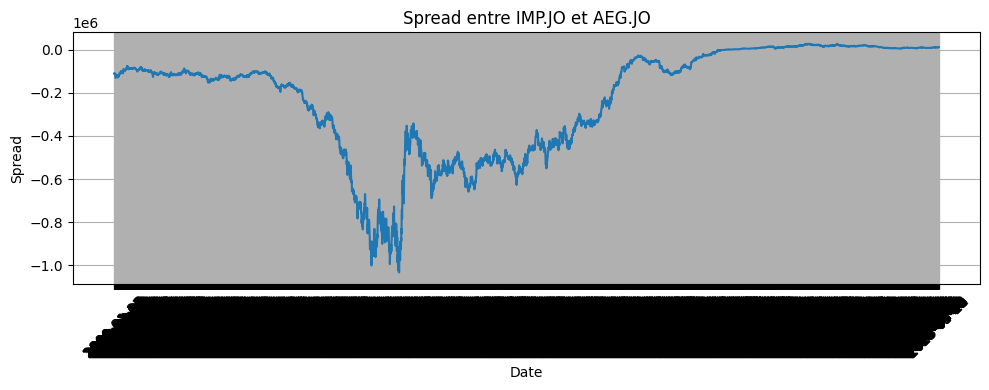

In [2]:
actif_1 = 'IMP.JO'
actif_2 = 'AEG.JO'

df_prices = pd.read_csv(r"C:\Users\lbenzemma\Desktop\Projets Master2 MOSEF\Kalman-Filtering-Applied-to-Investment-Portfolio-Management-1\data\jse_stocks.csv")
df = df_prices[['Date', actif_1, actif_2]].dropna().copy()

df['spread'] = df[actif_1] - df[actif_2]

plt.figure(figsize=(10, 4))
plt.plot(df['Date'], df['spread'])
plt.title(f"Spread entre {actif_1} et {actif_2}")
plt.xlabel("Date")
plt.ylabel("Spread")
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()


**Construire les états sₜ = [spread, position, temps]**

In [3]:
import numpy as np

# Générer une colonne "temps" normalisée entre 0 et 1
df['temps'] = np.linspace(0, 1, len(df))

# Position initiale = 0 (neutre) pour chaque ligne
df['position'] = 0

# Colonnes d'état à garder
state_cols = ['spread', 'position', 'temps']
states = df[state_cols].values

# Exemple d'états
print("Exemples d'états du MDP :")
print(states[:5])


Exemples d'états du MDP :
[[-1.10438751e+05  0.00000000e+00  0.00000000e+00]
 [-1.08316983e+05  0.00000000e+00  1.53798831e-04]
 [-1.08377169e+05  0.00000000e+00  3.07597662e-04]
 [-1.08377169e+05  0.00000000e+00  4.61396493e-04]
 [-1.11370694e+05  0.00000000e+00  6.15195325e-04]]


**Définir les actions aₜ possibles**

In [4]:
ACTIONS = {
    0: "Hold",
    1: "Enter Long",
    2: "Exit"
}

ACTION_SPACE = list(ACTIONS.keys())
print("Espace d'actions :", ACTION_SPACE)


Espace d'actions : [0, 1, 2]


**Définir l’environnement logique avec get_state() et step()**

In [18]:
def get_state(t, df, position):
    spread = df['spread'].iloc[t]
    spread_norm = (spread - df['spread'].mean()) / df['spread'].std()  
    time_ratio = t / len(df)
    return np.array([spread_norm, position, time_ratio], dtype=np.float32)

In [17]:
def step(t, df, position, entry_price, action, transaction_cost=50):
    # Normaliser ici aussi !
    spread_t = (df['spread'].iloc[t] - df['spread'].mean()) / df['spread'].std()
    spread_next = (df['spread'].iloc[t + 1] - df['spread'].mean()) / df['spread'].std()
    
    reward = 0
    done = False

    if action == 1 and position == 0:  # Enter
        position = 1
        entry_price = spread_t  # ← Maintenant normalisé
        reward -= transaction_cost

    elif action == 2 and position == 1:  # Exit
        pnl = spread_next - entry_price
        reward += pnl - transaction_cost  # ← PnL sera maintenant raisonnable
        position = 0
        entry_price = None

    elif action == 0 and position == 1:  # Hold
        reward += (spread_next - spread_t)  # ← Différence normalisée

    if action == 0 and position == 0:
        reward -= 1

    # Limiter les rewards (peut-être même réduire maintenant)
    reward = np.clip(reward, -100, 100)
    
    t += 1
    if t >= len(df) - 1:
        done = True

    next_state = get_state(t, df, position)
    return next_state, reward, position, entry_price, t, done

In [20]:
spread_series = df['spread'].values
t = 0
position = 0
entry_price = None

state = get_state(t, df, position)

next_state, reward, position, entry_price, t, done = step(
    t, df, position, entry_price, action=1
)


print("Next state:", next_state)
print("Reward:", reward)
print("Done?", done)


Next state: [4.6538764e-01 1.0000000e+00 1.5377518e-04]
Reward: -50
Done? False


**Créer le Q-network (Deep Q-learning)**

In [21]:
import torch
import torch.nn as nn

class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, output_dim)
        )

    def forward(self, x):
        return self.model(x)


In [22]:
input_dim = 3   # spread, position, temps
output_dim = 3  # Hold, Enter, Exit

q_net = QNetwork(input_dim=3, output_dim=3)


**Entraîner le Q-network (formule Bellman du papier)**

In [23]:
import torch.optim as optim

learning_rate = 0.001
gamma = 0.99  # facteur d'actualisation

optimizer = optim.Adam(q_net.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()


**Ajouter une politique ε-greedy (exploration)**

In [26]:
num_episodes = 50
transaction_cost = 100

spread_series  =df['spread'].values[:300]
rewards_all = []

for episode in range(num_episodes):
    # Initialisation
    t = 0
    position = 0
    entry_price = None
    done = False
    state = get_state(t, df, position)
    total_reward = 0

    while not done:
        state_tensor = torch.tensor(state).unsqueeze(0).float()

        # Choisir l'action (epsilon-greedy ici on peut commencer greedy pour simplifier)
        epsilon = max(0.1, 1.0 - episode / 50)

        if np.random.rand() < epsilon:
            action = np.random.choice(ACTION_SPACE)
        else:
            with torch.no_grad():
                q_values = q_net(state_tensor)
                action = torch.argmax(q_values).item()

        # Transition
        next_state, reward, position, entry_price, t, done = step(t, df, position, entry_price, action, 100)

        next_state_tensor = torch.tensor(next_state).unsqueeze(0).float()

        # Calcul de la cible Q
        with torch.no_grad():
            q_next = q_net(next_state_tensor)
            q_target = reward + gamma * torch.max(q_next).item() if not done else reward

        # Calcul de la loss
        q_pred = q_net(state_tensor)[0, action]
        loss = loss_fn(q_pred, torch.tensor(q_target).float())

        # Optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Mise à jour
        state = next_state
        total_reward += reward

    rewards_all.append(total_reward)

    if episode % 10 == 0:
        print(f"Épisode {episode} — Total reward : {total_reward:.2f}")




Épisode 0 — Total reward : -215559.99
Épisode 10 — Total reward : -175791.93
Épisode 20 — Total reward : -129142.61
Épisode 30 — Total reward : -87944.87
Épisode 40 — Total reward : -43134.50


c:\Users\lbenzemma\Desktop\Projets Master2 MOSEF\Kalman-Filtering-Applied-to-Investment-Portfolio-Management-1\env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


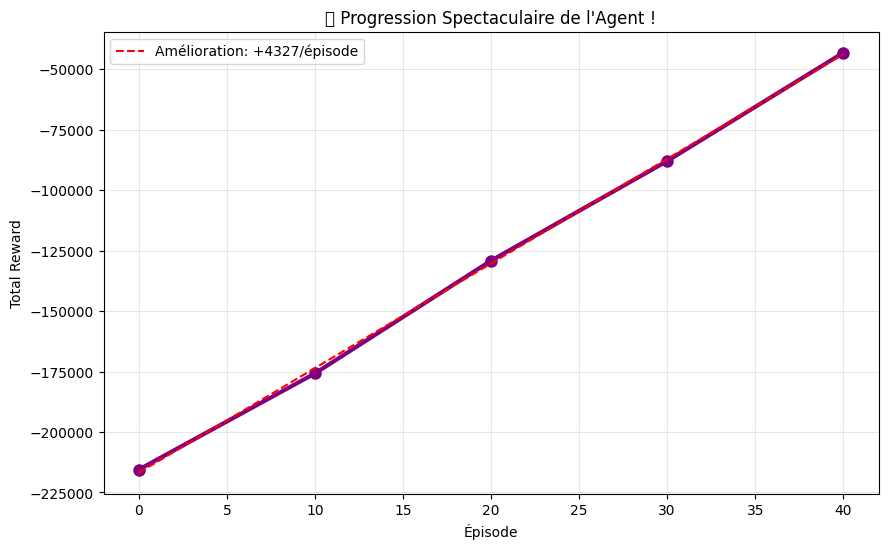

🎯 À ce rythme, épisode 50: -505


In [27]:
episodes = [0, 10, 20, 30, 40]
rewards = [-215559.99, -175791.93, -129142.61, -87944.87, -43134.50]

plt.figure(figsize=(10, 6))
plt.plot(episodes, rewards, 'o-', linewidth=3, markersize=8, color='purple')
plt.title('🚀 Progression Spectaculaire de l\'Agent !')
plt.xlabel('Épisode')
plt.ylabel('Total Reward')
plt.grid(True, alpha=0.3)

# Tendance
z = np.polyfit(episodes, rewards, 1)
plt.plot(episodes, np.poly1d(z)(episodes), "--", color='red', 
         label=f'Amélioration: +{z[0]:.0f}/épisode')
plt.legend()
plt.show()

print(f"🎯 À ce rythme, épisode 50: {np.poly1d(z)(50):.0f}")

In [16]:
print(df['spread'].describe())

count    6.503000e+03
mean    -2.247240e+05
std      2.501292e+05
min     -1.033289e+06
25%     -4.285524e+05
50%     -1.158954e+05
75%      1.545896e+03
max      2.766952e+04
Name: spread, dtype: float64


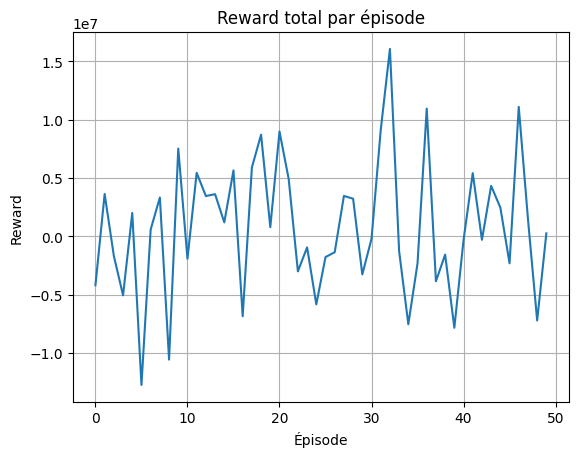

In [ ]:
import matplotlib.pyplot as plt

plt.plot(rewards_all)
plt.title("Reward total par épisode")
plt.xlabel("Épisode")
plt.ylabel("Reward")
plt.grid()
plt.show()
